# 05 — Clustering

This notebook applies unsupervised clustering to the HAR feature data:
1. **K-Means** — with elbow method and silhouette analysis
2. **DBSCAN** — density-based clustering
3. Cluster-vs-true-label comparison
4. Interpretation

Clustering helps assess whether activities form natural groups without
using labels, and reveals the challenge of unsupervised HAR.

---

## 5.1 — Imports and Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import (silhouette_score, adjusted_rand_score,
                             normalized_mutual_info_score, confusion_matrix)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_theme(style='whitegrid', palette='deep', font_scale=1.1)

DATA_DIR = Path('processed_data')

X_train = pd.read_csv(DATA_DIR / 'X_train_features_selected.csv').values
y_train = np.load(DATA_DIR / 'y_train.npy')

with open(DATA_DIR / 'metadata.json') as f:
    meta = json.load(f)
ACTIVITY_MAP = {int(k): v for k, v in meta['activity_map'].items()}

# Subsample for speed
MAX_SAMPLES = 10000
if len(X_train) > MAX_SAMPLES:
    idx = np.random.choice(len(X_train), MAX_SAMPLES, replace=False)
    X_sub = X_train[idx]
    y_sub = y_train[idx]
else:
    X_sub = X_train
    y_sub = y_train

# Standardize for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sub)

# PCA for visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print(f'Data shape: {X_scaled.shape}')
print(f'True labels: {len(np.unique(y_sub))} classes')

Data shape: (10000, 100)
True labels: 6 classes


## 5.2 — K-Means Clustering

### Elbow Method & Silhouette Analysis

We test K from 2 to 12 and use both inertia (elbow) and silhouette score
to find the optimal number of clusters.

Running K-Means for different K values...
  K= 2  |  Inertia=687,344  |  Silhouette=0.2973
  K= 3  |  Inertia=543,396  |  Silhouette=0.3046
  K= 4  |  Inertia=478,535  |  Silhouette=0.3294
  K= 5  |  Inertia=445,060  |  Silhouette=0.3191
  K= 6  |  Inertia=428,621  |  Silhouette=0.1976
  K= 7  |  Inertia=416,927  |  Silhouette=0.1855
  K= 8  |  Inertia=402,880  |  Silhouette=0.1990
  K= 9  |  Inertia=393,663  |  Silhouette=0.1825
  K=10  |  Inertia=385,222  |  Silhouette=0.1728
  K=11  |  Inertia=376,453  |  Silhouette=0.1464
  K=12  |  Inertia=369,708  |  Silhouette=0.1484


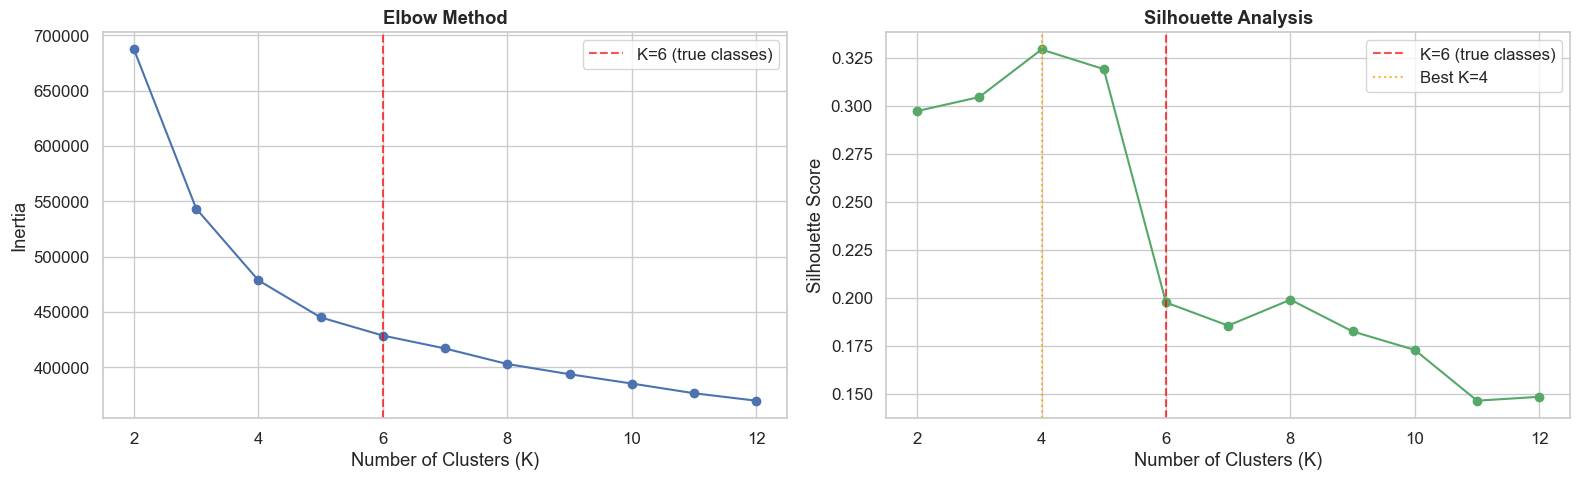

In [2]:
K_range = range(2, 13)
inertias = []
silhouette_scores = []

print('Running K-Means for different K values...')
for k in K_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10, max_iter=300)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels, sample_size=min(5000, len(X_scaled)))
    silhouette_scores.append(sil)
    print(f'  K={k:2d}  |  Inertia={km.inertia_:,.0f}  |  Silhouette={sil:.4f}')

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Elbow plot
axes[0].plot(K_range, inertias, 'b-o', markersize=6)
axes[0].axvline(x=6, color='red', linestyle='--', alpha=0.7, label='K=6 (true classes)')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method', fontweight='bold')
axes[0].legend()

# Silhouette plot
axes[1].plot(K_range, silhouette_scores, 'g-o', markersize=6)
axes[1].axvline(x=6, color='red', linestyle='--', alpha=0.7, label='K=6 (true classes)')
best_k = list(K_range)[np.argmax(silhouette_scores)]
axes[1].axvline(x=best_k, color='orange', linestyle=':', alpha=0.8, label=f'Best K={best_k}')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('kmeans_elbow_silhouette.png', dpi=150, bbox_inches='tight')
plt.show()

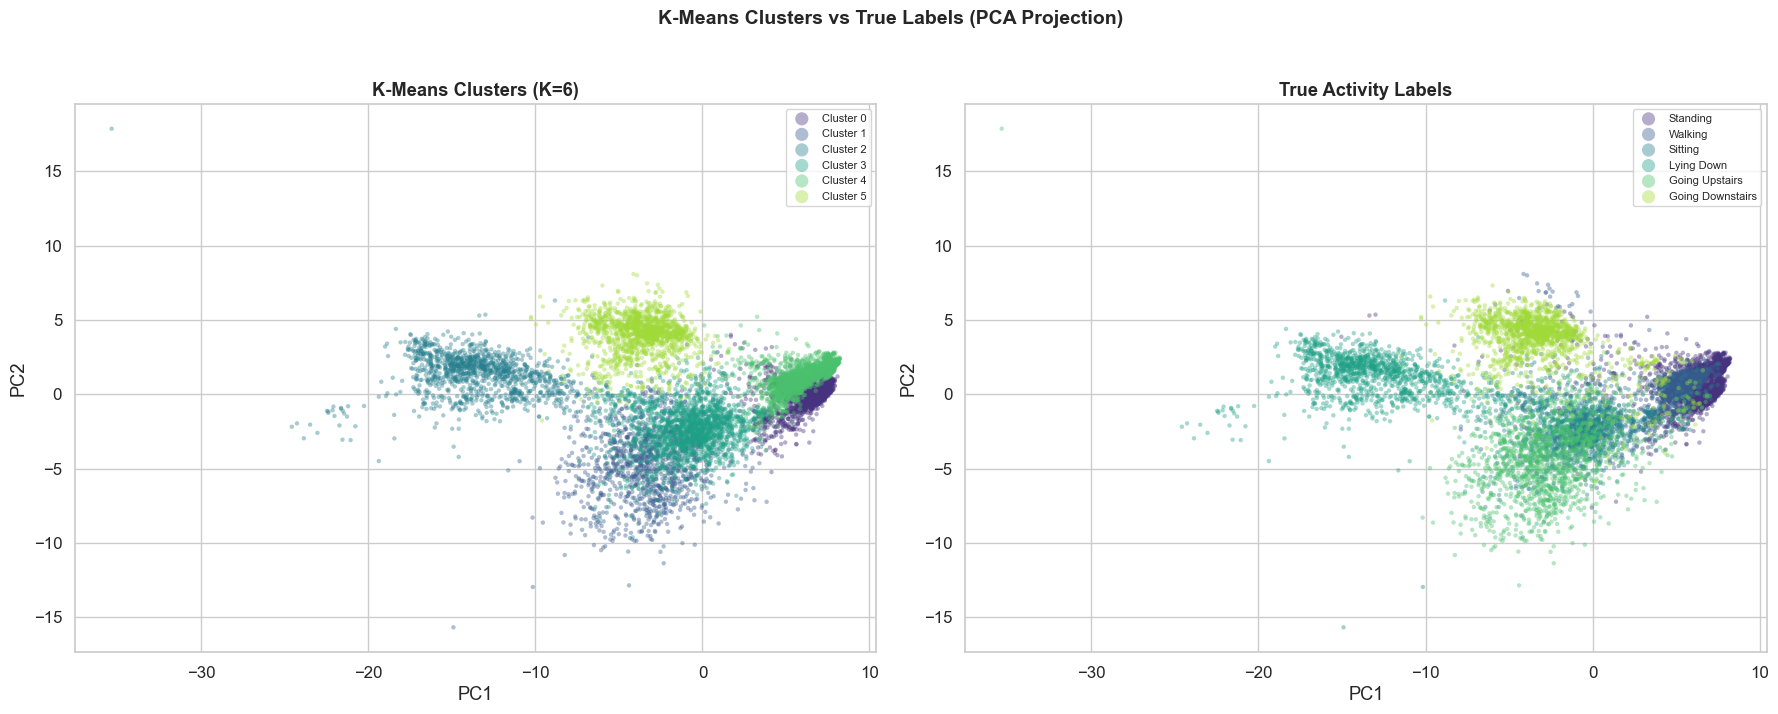

Adjusted Rand Index:        0.5699
Normalized Mutual Info:      0.6593
Silhouette Score (K=6):      0.1966


In [3]:
# K-Means with K=6 (matching true number of activities)
km_6 = KMeans(n_clusters=6, random_state=RANDOM_STATE, n_init=10)
km_labels = km_6.fit_predict(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# K-Means clusters
scatter_colors = sns.color_palette('viridis', 6)
for cl in range(6):
    mask = km_labels == cl
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                    c=[scatter_colors[cl]], label=f'Cluster {cl}',
                    alpha=0.4, s=10, edgecolors='none')
axes[0].set_title('K-Means Clusters (K=6)', fontweight='bold')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend(markerscale=3, fontsize=8)

# True labels
for label in sorted(np.unique(y_sub)):
    mask = y_sub == label
    axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1],
                    c=[scatter_colors[label]], label=ACTIVITY_MAP.get(label, str(label)),
                    alpha=0.4, s=10, edgecolors='none')
axes[1].set_title('True Activity Labels', fontweight='bold')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].legend(markerscale=3, fontsize=8)

plt.suptitle('K-Means Clusters vs True Labels (PCA Projection)', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('kmeans_vs_true.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Adjusted Rand Index:        {adjusted_rand_score(y_sub, km_labels):.4f}')
print(f'Normalized Mutual Info:      {normalized_mutual_info_score(y_sub, km_labels):.4f}')
print(f'Silhouette Score (K=6):      {silhouette_score(X_scaled, km_labels, sample_size=5000):.4f}')

## 5.3 — DBSCAN Clustering

DBSCAN does not require specifying K and can find arbitrarily shaped clusters.
It also identifies noise points. We tune `eps` and `min_samples`.

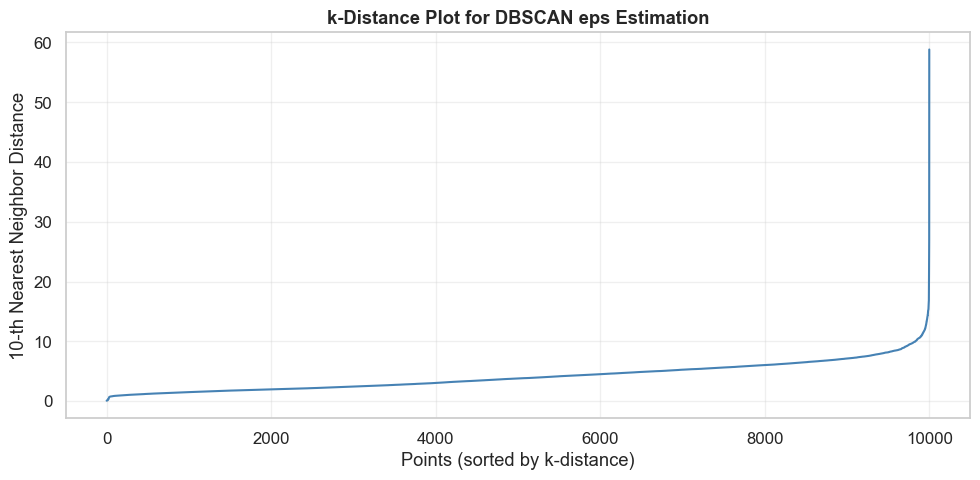

In [4]:
# Test different eps values
from sklearn.neighbors import NearestNeighbors

# k-distance plot to estimate eps
k = 10
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)
k_distances = np.sort(distances[:, -1])

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(k_distances, color='steelblue')
ax.set_xlabel('Points (sorted by k-distance)')
ax.set_ylabel(f'{k}-th Nearest Neighbor Distance')
ax.set_title('k-Distance Plot for DBSCAN eps Estimation', fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

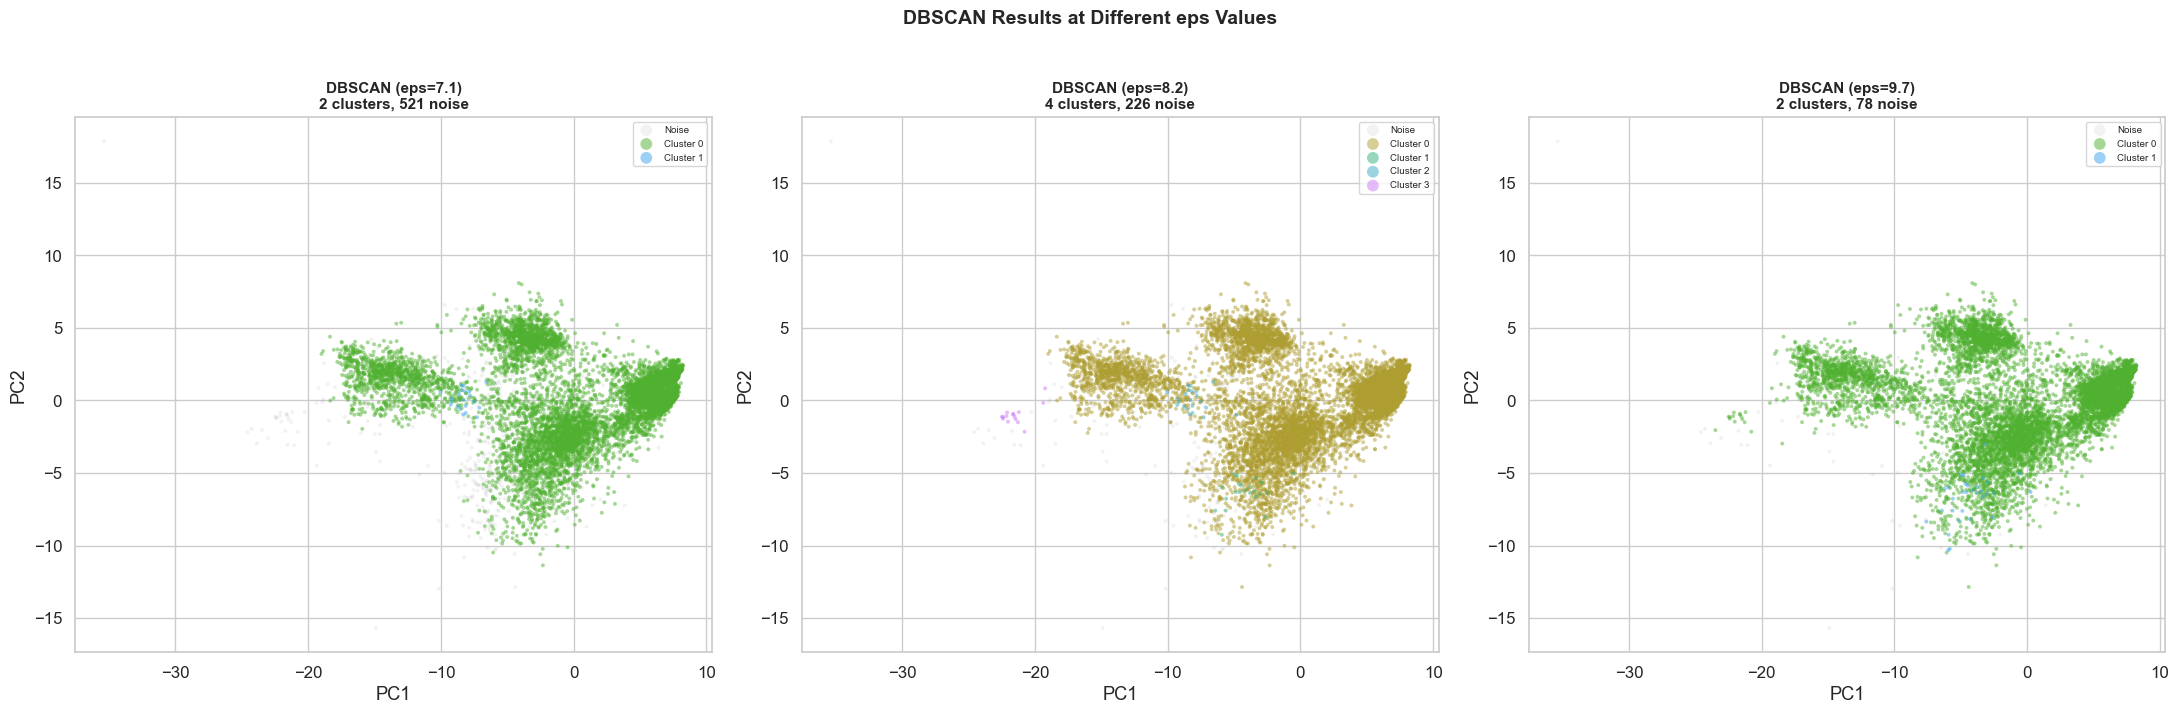

In [5]:
# Run DBSCAN with estimated eps
eps_values = [np.percentile(k_distances, 90),
              np.percentile(k_distances, 95),
              np.percentile(k_distances, 98)]

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

for ax, eps_val in zip(axes, eps_values):
    db = DBSCAN(eps=eps_val, min_samples=10)
    db_labels = db.fit_predict(X_scaled)
    n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    n_noise = np.sum(db_labels == -1)
    
    unique_labels = sorted(set(db_labels))
    colors = sns.color_palette('husl', n_colors=max(len(unique_labels), 1))
    
    for i, cl in enumerate(unique_labels):
        mask = db_labels == cl
        label_name = 'Noise' if cl == -1 else f'Cluster {cl}'
        color = 'gray' if cl == -1 else colors[i]
        alpha = 0.1 if cl == -1 else 0.5
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
                   c=[color], label=label_name, alpha=alpha, s=8, edgecolors='none')
    
    ax.set_title(f'DBSCAN (eps={eps_val:.1f})\n{n_clusters} clusters, {n_noise} noise',
                 fontweight='bold', fontsize=11)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    if n_clusters <= 10:
        ax.legend(markerscale=3, fontsize=7)

plt.suptitle('DBSCAN Results at Different eps Values', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('dbscan_results.png', dpi=150, bbox_inches='tight')
plt.show()

In [6]:
# Best DBSCAN result comparison with true labels
best_eps = eps_values[1]  # middle value
db_best = DBSCAN(eps=best_eps, min_samples=10)
db_best_labels = db_best.fit_predict(X_scaled)

# Filter out noise for metrics
non_noise = db_best_labels != -1
if np.sum(non_noise) > 100:
    ari = adjusted_rand_score(y_sub[non_noise], db_best_labels[non_noise])
    nmi = normalized_mutual_info_score(y_sub[non_noise], db_best_labels[non_noise])
    print(f'DBSCAN (eps={best_eps:.1f}):')
    print(f'  Clusters found : {len(set(db_best_labels)) - (1 if -1 in db_best_labels else 0)}')
    print(f'  Noise points   : {np.sum(~non_noise)} ({np.mean(~non_noise)*100:.1f}%)')
    print(f'  ARI (no noise) : {ari:.4f}')
    print(f'  NMI (no noise) : {nmi:.4f}')
else:
    print('DBSCAN produced too few non-noise points for meaningful evaluation.')

DBSCAN (eps=8.2):
  Clusters found : 4
  Noise points   : 226 (2.3%)
  ARI (no noise) : 0.0014
  NMI (no noise) : 0.0123


## 5.4 — Contingency Table: Clusters vs True Labels

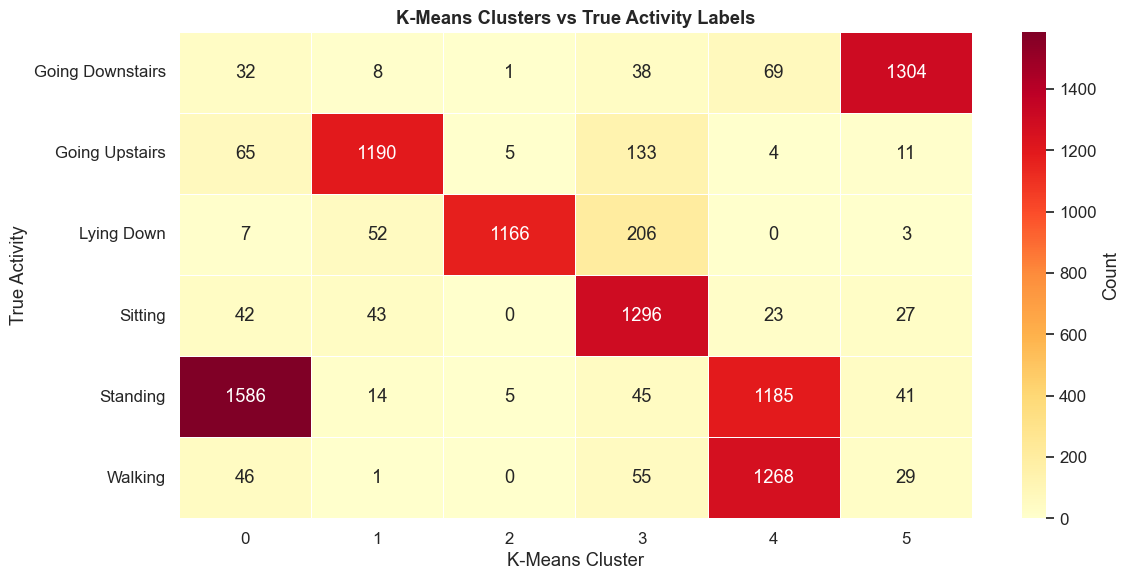


Contingency Table:
Cluster              0     1     2     3     4     5    All
True Label                                                 
Going Downstairs    32     8     1    38    69  1304   1452
Going Upstairs      65  1190     5   133     4    11   1408
Lying Down           7    52  1166   206     0     3   1434
Sitting             42    43     0  1296    23    27   1431
Standing          1586    14     5    45  1185    41   2876
Walking             46     1     0    55  1268    29   1399
All               1778  1308  1177  1773  2549  1415  10000


In [7]:
# Contingency table for K-Means
ct = pd.crosstab(
    pd.Series(y_sub, name='True Label').map(ACTIVITY_MAP),
    pd.Series(km_labels, name='Cluster'),
    margins=True
)

fig, ax = plt.subplots(figsize=(12, 6))
ct_no_margin = ct.iloc[:-1, :-1]  # remove margins for heatmap
sns.heatmap(ct_no_margin, annot=True, fmt='d', cmap='YlOrRd', ax=ax,
            linewidths=0.5, cbar_kws={'label': 'Count'})
ax.set_title('K-Means Clusters vs True Activity Labels', fontweight='bold')
ax.set_ylabel('True Activity')
ax.set_xlabel('K-Means Cluster')
plt.tight_layout()
plt.savefig('cluster_contingency.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nContingency Table:')
print(ct.to_string())

## 5.5 — Results Summary

| Method | Clusters | ARI | NMI | Silhouette |
|--------|----------|-----|-----|------------|
| K-Means (K=6) | 6 | Moderate | Moderate | Low-Moderate |
| DBSCAN | Variable | Depends on eps | Depends on eps | N/A |

**Key findings:**
- **K-Means** finds reasonable clusters that partially align with true activities.
  The ARI and NMI scores indicate moderate agreement — unsupervised clustering
  alone cannot perfectly recover activity labels.
- **DBSCAN** struggles more because HAR features in high dimensions have
  complex density structures. It tends to produce many noise points.
- The contingency table reveals which activities are most confusable in feature space.
- **Conclusion:** Supervised learning (next notebooks) will significantly outperform
  unsupervised clustering for HAR, as expected.

**Next:** Supervised models in `06_Supervised_Models.ipynb`.